# 為替レートと株価の相関 (2)

In [1]:
import datetime as dt
import japanize_matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import mplfinance as mpf
import numpy as np
import os
import pandas as pd
import yfinance as yf
import wget

## 共通用途の関数

In [2]:
# インデックスの時刻情報を取り除く
def conv_index_datetime_date(df: pd.DataFrame) -> pd.DataFrame:
    df.index = pd.to_datetime(['%d-%02d-%02d' % (ts.year, ts.month, ts.day) for ts in df.index])
    return df

In [3]:
# 東証上場銘柄情報の取得
def get_tickers_tse() -> pd.DataFrame:
    tse = "https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls"
    filename = wget.download(tse)
    df = pd.read_excel(filename)[['コード', '銘柄名', '市場・商品区分']]
    os.remove(filename)
    return df

## データスコープと為替レートのインスタンス

In [4]:
start = '2024-05-01'
end = '2024-08-10'
ticker_exchange = yf.Ticker('USDJPY=X')

## １時間足の為替データを取得

In [5]:
df_hour = ticker_exchange.history(start=start, end=end, interval='1h')[['Open', 'High', 'Low', 'Close']]

# タイムゾーンを日本時間に変換
df_hour.index = df_hour.index.tz_convert('Asia/Tokyo')
df_hour

,Open,High,Low,Close
Datetime,,,,
2024-05-01 08:00:00+09:00,157.695999,157.751007,157.673004,157.746994
2024-05-01 09:00:00+09:00,157.737000,157.856003,157.677994,157.744003
2024-05-01 10:00:00+09:00,157.744003,157.848007,157.725998,157.800995
2024-05-01 11:00:00+09:00,157.798996,157.893005,157.787994,157.876999
2024-05-01 12:00:00+09:00,157.882996,157.934998,157.835007,157.912994
...,...,...,...,...
2024-08-09 09:00:00+09:00,147.688995,147.774994,147.194000,147.475998
2024-08-09 10:00:00+09:00,147.481995,147.615005,147.074005,147.084000
2024-08-09 11:00:00+09:00,147.084000,147.505005,147.016006,147.481003


### 終値を使うため、午後 14:00 のデータのみ抽出

In [6]:
list_day = sorted(list(set(['%d-%02d-%02d 14:00:00+09:00' % (ts.year, ts.month, ts.day) for ts in df_hour.index])))
list_series = list()
for ts in list_day:
    try:
        series = df_hour.loc[ts]
        list_series.append(series)
    except KeyError:
        print('no key of \'%s\'' % ts)
df_exchange = pd.concat(list_series, axis=1).T
print(df_exchange.head())

no key of '2024-05-04 14:00:00+09:00'
no key of '2024-05-11 14:00:00+09:00'
no key of '2024-05-18 14:00:00+09:00'
no key of '2024-05-25 14:00:00+09:00'
no key of '2024-06-01 14:00:00+09:00'
no key of '2024-06-08 14:00:00+09:00'
no key of '2024-06-15 14:00:00+09:00'
no key of '2024-06-22 14:00:00+09:00'
no key of '2024-06-29 14:00:00+09:00'
no key of '2024-07-06 14:00:00+09:00'
no key of '2024-07-13 14:00:00+09:00'
no key of '2024-07-20 14:00:00+09:00'
no key of '2024-07-27 14:00:00+09:00'
no key of '2024-08-03 14:00:00+09:00'
no key of '2024-08-09 14:00:00+09:00'
                                 Open        High         Low       Close
2024-05-01 14:00:00+09:00  157.854996  157.923004  157.817993  157.919998
2024-05-02 14:00:00+09:00  155.824005  155.889999  155.589996  155.695007
2024-05-03 14:00:00+09:00  152.912994  153.063004  152.843002  152.988007
2024-05-06 14:00:00+09:00  153.929993  153.977997  153.867996  153.921005
2024-05-07 14:00:00+09:00  154.472000  154.552994  154.37500

### インデックスの時刻情報を取り除く

In [7]:
df_exchange = conv_index_datetime_date(df_exchange)
df_exchange

,Open,High,Low,Close
2024-05-01,157.854996,157.923004,157.817993,157.919998
2024-05-02,155.824005,155.889999,155.589996,155.695007
2024-05-03,152.912994,153.063004,152.843002,152.988007
2024-05-06,153.929993,153.977997,153.867996,153.921005
2024-05-07,154.472000,154.552994,154.375000,154.539993
...,...,...,...,...
2024-08-02,149.259003,149.373001,148.886002,148.944000
2024-08-05,143.171997,143.487000,142.408997,142.660004
2024-08-06,145.507996,146.141998,145.100998,145.867004
2024-08-07,147.612000,147.813995,146.834000,146.979004


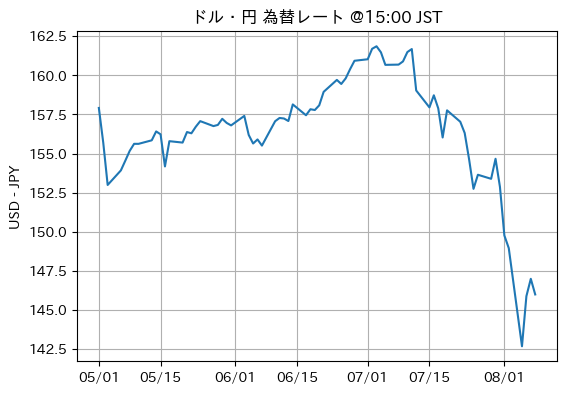

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(df_exchange.index, df_exchange['Close'])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.set_title('ドル・円 為替レート @15:00 JST')
ax.set_ylabel('USD - JPY')
ax.grid()

fig.subplots_adjust(left=0.15, right=0.95, bottom=0.075, top=0.9)
plt.savefig('report_20240809_exchange_corr_0.png')

plt.show()

### 為替レートの Close を Series に

In [9]:
series_exchange = df_exchange['Close']
series_exchange.name = 'USDJPY'
series_exchange

2024-05-01    157.919998
2024-05-02    155.695007
2024-05-03    152.988007
2024-05-06    153.921005
2024-05-07    154.539993
                 ...    
2024-08-02    148.944000
2024-08-05    142.660004
2024-08-06    145.867004
2024-08-07    146.979004
2024-08-08    145.979004
Name: USDJPY, Length: 72, dtype: float64

## 東証上場銘柄情報の取得

In [10]:
df_tse = get_tickers_tse()
df_tse

100% [........................................................] 810496 / 810496

,コード,銘柄名,市場・商品区分
0,1301,極洋,プライム（内国株式）
1,1305,ｉＦｒｅｅＥＴＦ ＴＯＰＩＸ（年１回決算型）,ETF・ETN
2,1306,ＮＥＸＴ ＦＵＮＤＳ ＴＯＰＩＸ連動型上場投信,ETF・ETN
3,1308,上場インデックスファンドＴＯＰＩＸ,ETF・ETN
4,1309,ＮＥＸＴ ＦＵＮＤＳ ＣｈｉｎａＡＭＣ・中国株式・上証５０連動型上場投信,ETF・ETN
...,...,...,...
4378,9991,ジェコス,プライム（内国株式）
4379,9993,ヤマザワ,スタンダード（内国株式）
4380,9994,やまや,スタンダード（内国株式）
4381,9996,サトー商会,スタンダード（内国株式）


In [11]:
sorted(list(set(df_tse['市場・商品区分'])))

['ETF・ETN',
 'PRO Market',
 'REIT・ベンチャーファンド・カントリーファンド・インフラファンド',
 'グロース（内国株式）',
 'グロース（外国株式）',
 'スタンダード（内国株式）',
 'スタンダード（外国株式）',
 'プライム（内国株式）',
 'プライム（外国株式）',
 '出資証券']

In [12]:
list_market = [
    'グロース（内国株式）',
    'スタンダード（内国株式）',
    'プライム（内国株式）',
]
df_targets = df_tse[df_tse['市場・商品区分'].isin(list_market)]

# 必要な列の抽出と、コードの列を明示的に文字型に変換
df_targets = pd.concat([df_targets['コード'].astype(str), df_targets['銘柄名'], df_targets['市場・商品区分']], axis=1)
df_targets

,コード,銘柄名,市場・商品区分
0,1301,極洋,プライム（内国株式）
5,130A,Ｖｅｒｉｔａｓ Ｉｎ Ｓｉｌｉｃｏ,グロース（内国株式）
19,1332,ニッスイ,プライム（内国株式）
20,1333,マルハニチロ,プライム（内国株式）
31,135A,ＶＲＡＩＮ Ｓｏｌｕｔｉｏｎ,グロース（内国株式）
...,...,...,...
4378,9991,ジェコス,プライム（内国株式）
4379,9993,ヤマザワ,スタンダード（内国株式）
4380,9994,やまや,スタンダード（内国株式）
4381,9996,サトー商会,スタンダード（内国株式）


In [13]:
dict_corr = dict()
for code in df_targets['コード']:
    symbol = '%s.T' % code
    ticker = yf.Ticker(symbol)
    df_ticker = ticker.history(start=start, end=end)
    # インデックスの時刻情報を取り除く
    df_ticker = conv_index_datetime_date(df_ticker)
    series_ticker = df_ticker['Close']
    series_ticker.name = code
    df_corr = pd.concat([series_exchange, series_ticker], axis=1, join='inner')
    corr = float(df_corr.corr().loc[code, 'USDJPY']) * 100
    if np.isnan(corr):
        continue
    dict_corr[code] = corr

21649.T: Period '1mo' is invalid, must be one of ['1d', '5d']
$94345.T: possibly delisted; No timezone found


In [14]:
df_result = pd.DataFrame(
    dict_corr,
    index=['corr']
).T
df_result

,corr
1301,57.218874
130A,38.399474
1332,13.977967
1333,24.186953
135A,59.809886
...,...
9991,84.861537
9993,77.521469
9994,73.722186
9996,66.771623


In [15]:
df_result_negative = df_result.sort_values('corr', ascending=False).tail(30)
df_result_negative['cname'] = ['%s (%s)' % (df_targets.loc[df_targets['コード'] == code, '銘柄名'].iloc[0], code) for code in df_result_negative.index]
df_result_negative

,corr,cname
3791,-52.330707,ＩＧポート (3791)
5809,-52.437967,タツタ電線 (5809)
2327,-52.946035,日鉄ソリューションズ (2327)
3841,-54.924187,ジーダット (3841)
5423,-54.932698,東京製鐵 (5423)
7928,-56.028547,旭化学工業 (7928)
3623,-56.490385,ビリングシステム (3623)
9602,-56.963907,東宝 (9602)
9241,-57.141016,フューチャーリンクネットワーク (9241)
4597,-59.262317,ソレイジア・ファーマ (4597)


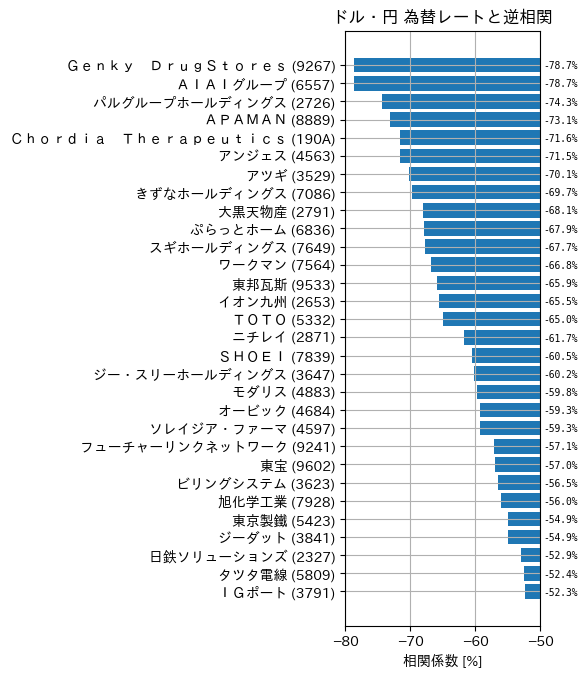

In [80]:
fig, ax = plt.subplots(figsize=(6, 7))

ax.barh(df_result_negative['cname'], df_result_negative['corr'])

ax.set_title('ドル・円 為替レートと逆相関')
ax.set_xlabel('相関係数 [%]')
ax.set_xlim(-80, -50)
ax.grid(axis = 'both')

for i, v in enumerate(df_result_negative['corr']):
    ax.text(-49.5, i - 0.2, '%+.1f%%' % v, color = 'black', fontfamily='monospace', fontsize='x-small')

fig.subplots_adjust(left=0.6, right=0.925, bottom=0.1, top=0.95)
plt.savefig('report_20240809_exchange_corr_1.png')
plt.show()

In [17]:
df_result_positive = df_result.sort_values('corr', ascending=True).tail(30)
df_result_positive['cname'] = ['%s (%s)' % (df_targets.loc[df_targets['コード'] == code, '銘柄名'].iloc[0], code) for code in df_result_positive.index]
df_result_positive

,corr,cname
220A,90.633595,Ｆａｂｅｒ Ｃｏｍｐａｎｙ (220A)
1848,90.725692,富士ピー・エス (1848)
8137,90.799463,サンワテクノス (8137)
7245,90.814858,大同メタル工業 (7245)
6382,90.933464,トリニティ工業 (6382)
7607,91.192967,進和 (7607)
4668,91.275601,明光ネットワークジャパン (4668)
9979,91.303494,大庄 (9979)
7809,91.405252,壽屋 (7809)
4538,91.453682,扶桑薬品工業 (4538)


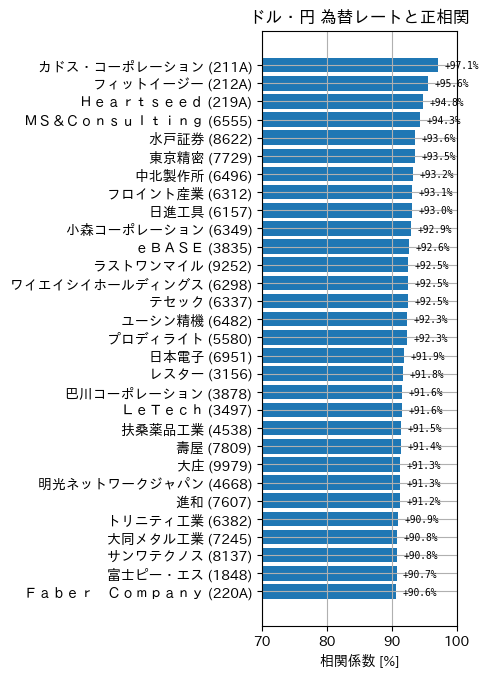

In [81]:
fig, ax = plt.subplots(figsize=(6, 7))

ax.barh(df_result_positive['cname'], df_result_positive['corr'])

ax.set_title('ドル・円 為替レートと正相関')
ax.set_xlabel('相関係数 [%]')
ax.set_xlim(70, 100)
ax.grid(axis = 'both')

for i, v in enumerate(df_result_positive['corr']):
    ax.text(v + 1, i - 0.2, '%+.1f%%' % v, color = 'black', fontfamily='monospace', fontsize='x-small')

fig.subplots_adjust(left=0.6, right=0.925, bottom=0.1, top=0.95)
plt.savefig('report_20240809_exchange_corr_2.png')
plt.show()

In [19]:
df_result_neutral = df_result.sort_values('corr', key=lambda s: np.abs(s), ascending=False).tail(30)
df_result_neutral['cname'] = ['%s (%s)' % (df_targets.loc[df_targets['コード'] == code, '銘柄名'].iloc[0], code) for code in df_result_neutral.index]
df_result_neutral

,corr,cname
4375,-1.868806,セーフィー (4375)
2220,1.861287,亀田製菓 (2220)
7860,-1.837829,エイベックス (7860)
9795,1.815155,ステップ (9795)
2404,1.789164,鉄人化ホールディングス (2404)
3092,-1.789052,ＺＯＺＯ (3092)
1383,1.746607,ベルグアース (1383)
3141,-1.690963,ウエルシアホールディングス (3141)
9249,1.585036,日本エコシステム (9249)
3666,-1.578961,テクノスジャパン (3666)


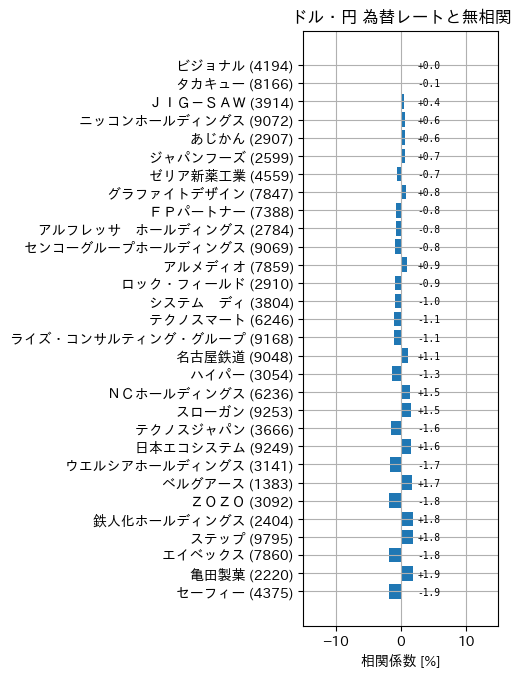

In [82]:
fig, ax = plt.subplots(figsize=(6, 7))

ax.barh(df_result_neutral['cname'], df_result_neutral['corr'])

ax.set_title('ドル・円 為替レートと無相関')
ax.set_xlabel('相関係数 [%]')
ax.set_xlim(-15, 15)
ax.grid(axis = 'both')

for i, v in enumerate(df_result_neutral['corr']):
    ax.text(2.5, i - 0.2, '%+.1f' % v, color = 'black', fontfamily='monospace', fontsize='x-small')

fig.subplots_adjust(left=0.6, right=0.925, bottom=0.1, top=0.95)
plt.savefig('report_20240809_exchange_corr_3.png')
plt.show()